# Autonomous Vehicles Animal Detection

Run the following cell if you are working on colab

In [4]:
!git clone https://github.com/Giovannicus/AnimalRec.git
%cd /content/AnimalRec
%pwd

Cloning into 'AnimalRec'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 61 (delta 29), reused 35 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 719.90 KiB | 3.87 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/AnimalRec


'/content/AnimalRec'

In [5]:
import eda_batch
from logo import logo
import tarfile
import os
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import RandomNormal

import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold

In [6]:
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, Y_train), (x_test, y_test) = load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [16]:
logo()

# EDA

Try printing an image

In [17]:
labels = ['airplane','automobile','bird','cat','deer','dog',\
          'frog','horse','ship','truck']

Image label automobile


<ipython-input-18-ca55b4b16330>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Image label {labels[int(y_train[0])]}")


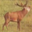

In [18]:
print(f"Image label {labels[int(y_train[0])]}")
Image.fromarray(x_train[0])


# Preprocessing

Convert classes to binary animal or not

In [7]:
Y_train = ((Y_train >= 2) & (Y_train < 8)).astype(int)
y_test = ((y_test >= 2) & (y_test < 8)).astype(int)

### Pieplot target distribution

In [8]:
fig = go.Figure(data=[go.Pie(labels=["Animal", "Not animal"],
                             values=[np.mean(Y_train), 1 - np.mean(Y_train)],
                             hoverinfo="label+percent",  # Mostra etichetta, percentuale e valore
                             textinfo='percent',  # Mostra solo la percentuale sulle fette

                             pull=[0, 0.01],  # Evidenzia la seconda fetta
                             marker=dict(colors=['#FF0000', '#408040']),  # Colori personalizzati
                             textfont=dict(size=18)
                             )])


fig.update_layout(
    paper_bgcolor = "rgba(0,0,0,1)",
    plot_bgcolor = "rgba(0,0,0,1)",
    title={
        'text': "Target distribution",
        'font': {'color': 'white'}
    },
    font=dict(
        color='white',
        size=18
    ),
    legend=dict(
        font=dict(color='white')
    )
)

# Mostra il grafico
fig.show()

Distribution is fairly balanced

### Data augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale = 1/255.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    )

val_datagen = ImageDataGenerator(
    rescale = 1/255.,
)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=.1,stratify=Y_train)

In [11]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)

# Model

## Transfer Learning

Use pre-trained vgg16 model freezing its conv layers

In [12]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in vgg16.layers:
    layer.trainable = False
vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


add dense layers by yourself

In [13]:
w_init = RandomNormal(stddev=0.01)
x = vgg16.output
x = Flatten() (x)
#x = Dropout(0.2) (x)
x = Dense(1024, activation='relu') (x)
x = Dense(128, activation='relu') (x)
x = Dense(16, activation='relu') (x)
x = Dropout(0.2) (x)
x = Dense(1, activation='sigmoid') (x)

In [17]:
clear_session()
model = Model(inputs=vgg16.input, outputs=x,name="vgg16_mod")
model.summary()

Model: "vgg16_mod"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,946,145 (64.64 MB)

 Trainable params: 2,231,457 (8.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', "precision"])
n_epochs = 25
hist = model.fit(train_generator,
              validation_data=val_generator,
              epochs=n_epochs,
              initial_epoch=0,
              verbose=1,
              callbacks =[early_stopping])

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



704/704 ━━━━━━━━━━━━━━━━━━━━ 52s 64ms/step - accuracy: 0.7789 - loss: 0.4659 - precision: 0.8070 - val_accuracy: 0.8446 - val_loss: 0.3516 - val_precision: 0.8772
Epoch 2/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.8431 - loss: 0.3627 - precision: 0.8556 - val_accuracy: 0.8558 - val_loss: 0.3316 - val_precision: 0.9092
Epoch 3/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8513 - loss: 0.3466 - precision: 0.8628 - val_accuracy: 0.8686 - val_loss: 0.3010 - val_precision: 0.8880
Epoch 4/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8548 - loss: 0.3383 - precision: 0.8676 - val_accuracy: 0.8704 - val_loss: 0.3039 - val_precision: 0.9016
Epoch 5/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.8611 - loss: 0.3276 - precision: 0.8744 - val_accuracy: 0.8718 - val_loss: 0.2941 - val_precision: 0.8689
Epoch 6/25
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8678 - loss: 0.3174 - precision: 0.8806 - val_accuracy: 0.8594 - val_loss

Save model and hist

In [19]:
model.save('vgg16_mod.h5')
import json


hist_dict = hist.history
with open('hist.json', 'w') as f:
    json.dump(hist_dict, f)


Load model and hist

In [20]:
import json

with open('hist.json', 'r') as f:
    hist = json.load(f)

from tensorflow.keras.models import load_model

model = load_model('vgg16_mod.h5')

# Results

Let's send output on brower avoiding visualization issues on VSC

In [31]:
import plotly.io as pio

pio.renderers.default = 'browser'

fig.show()

Error: could not locate runnable browser

In [1]:
plot_training_metrics(hist)

NameError: name 'plot_training_metrics' is not defined

In [1]:
import plotly.graph_objects as go
import numpy as np

def plot_training_metrics(hist):
    epochs = np.arange(1, len(hist["loss"]) + 1)
    metrics = ["loss", "accuracy", "precision"]

    fig = go.Figure()

    for metric in metrics:
        fig.add_trace(go.Scatter(x=epochs, y=hist[metric], mode='lines',
                                 name=f'Training {metric}',
                                 line=dict(color='blue'),
                                 visible=(metric == "loss")))
        fig.add_trace(go.Scatter(x=epochs, y=hist[f'val_{metric}'], mode='lines',
                                 name=f'Validation {metric}',
                                 line=dict(color='orange'),
                                 visible=(metric == "loss")))

    dropdown_menu = []
    for i, metric in enumerate(metrics):
        dropdown_menu.append(dict(
            args=[{'visible': [False] * len(metrics) * 2},
                  {'title': f'{metric.capitalize()} over Epochs',
                   'yaxis': {'title': metric.capitalize()}}],
            label=metric.capitalize(),
            method='update'
        ))
        dropdown_menu[i]['args'][0]['visible'][i*2] = True  # Training metric
        dropdown_menu[i]['args'][0]['visible'][i*2+1] = True  # Validation metric

    fig.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=dropdown_menu,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,  # Moved down slightly
            yanchor="top"
        )],
        title="Model Training Metrics",
        xaxis_title="Epochs",
        yaxis_title="Loss",
        height=600,
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='black',
        showline=True,  # Show x-axis line
        linewidth=2,
        linecolor='black',
        dtick=1  # Set tick interval to 1
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='black',
        showline=True,  # Show y-axis line
        linewidth=2,
        linecolor='black'
    )

    fig.show()